<a href="https://colab.research.google.com/github/spchanakya/Food-Quality-Classification/blob/main/MNV2_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import important Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import seaborn as sn
import warnings
warnings.filterwarnings('ignore')
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor , RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score,roc_curve,classification_report,auc,mean_absolute_error
from keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.applications import MobileNetV2  # further i will be training this dataset on some predefined architectures
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model,Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# important functions

In [91]:
def plot_conf_matrix(A,B,C=str(''),D=str(' ')):
  conf_matrix = confusion_matrix(A,B)
  plt.figure(figsize=(6,5))
  sn.heatmap(conf_matrix,annot=True, fmt='', cmap='rocket_r')
  title="Confusion Matrix for "+str(C)+" "+str(D)
  plt.title(title)
  plt.ylabel('Predicted Class')
  plt.xlabel('Target Class')
  plt.savefig(str(title))
  plt.show()
  return()
def plot_classification_report(A,B):
  print('\n*Classification Report:\n', classification_report(A,B))
  return()
def plot_ROC_details(A,B):
  fpr, tpr, thresholds = roc_curve(A,B,pos_label=1)
  auc=roc_auc_score(A,B,average='macro')
  print("AUC :%.3f" %auc)
  acc_score=accuracy_score(A,B)
  print("Accuracy score :%.3f" %acc_score)
  fig, ax = plt.subplots(figsize=(6, 6))
  plt.plot(fpr, tpr, label='ROC Curve 1 (AUC = %0.2f)' )
  plt.title("ROC curve")
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.show()
  return()
def plot_acc_loss_curve(A,B,C = str(' ')):
  result_df = pd.DataFrame(A.history)
  fig, ax=plt.subplots(nrows=1, ncols=2,figsize=(18,6))
  ax=ax.flatten()
  ax[0].plot(result_df[['accuracy','val_accuracy']])
  ax[0].set_title("Accuracy")
  ax[0].set_ylim(0,1.01)
  ax[0].set_ylabel("Accuracy") # yaxis for left side plot
  ax[0].set_xlabel("Epochs")# xaxis for left side plot
  ax[0].legend(['Training_Accuracy', 'val_accuracy'], loc='upper left')
  ax[1].plot(result_df[['loss','val_loss']])
  ax[1].set_title("Loss")
  ax[1].set_ylabel("Loss")# yaxis for right side plot
  ax[1].set_xlabel("Epochs")# xaxis for right side plot
  ax[1].legend(['Training_Loss', 'val_loss'], loc='upper right')
  if C == str(' '):
    title='Results of '+ str(B) +' Model'
    fig.suptitle(title, fontsize=16)
    plt.savefig(str(title))
  else:
    title='Results of '+ str(B) +' Model for '+str(C)+'classification'
    fig.suptitle(title, fontsize=16)
    plt.savefig(str(title))
  return()

# Preparing the data

## Loading the dataset into pandas dataset (no more needed to run)

In [ ]:
Training_data = '/content/drive/MyDrive/Final_Dataset/Train' # This is a sample of the whole Training dataset I am using
Test_data = '/content/drive/MyDrive/Final_Dataset/Test' # This is a sample of the whole test dataset I am using

In [4]:
img_shape=(224,224) # target image sixe
batch_size = 64 # batch size for training
Seed = 8  # random seed for reproducibility
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                 validation_split=0.3)
test_datagen =ImageDataGenerator(preprocessing_function= preprocess_input)

In [ ]:
import os
from PIL import Image
def Create_DF(i):
  folder_path=i
  data = {'Image': [], 'FolderName': []}
  for folder_name in os.listdir(folder_path):
      folder_full_path = os.path.join(folder_path, folder_name)
      if os.path.isdir(folder_full_path):
          for image_file in os.listdir(folder_full_path):
              if image_file.endswith('.jpg') or image_file.endswith('.png'):
                  image_path = os.path.join(folder_full_path, image_file)
                  img = Image.open(image_path)
                  img = img.resize(img_shape)
                  img_array = np.array(img)
                  data['Image'].append(img_array)
                  data['FolderName'].append(folder_name)
  df = pd.DataFrame(data)
  return df

In [ ]:
Train_df=Create_DF(Training_data)
Test_df=Create_DF(Test_data)

In [ ]:
# prompt: save the crested dataframes usinga corretc format for numpy array

Train_df.to_pickle('/content/drive/MyDrive/Train_df.pkl')
Test_df.to_pickle('/content/drive/MyDrive/Test_df.pkl')

## loading the dataframe

In [5]:
import pickle

with open('/content/drive/MyDrive/Train_df.pkl', 'rb') as file:
    Train_df = pickle.load(file)
with open('/content/drive/MyDrive/Test_df.pkl', 'rb') as file:
    Test_df = pickle.load(file)


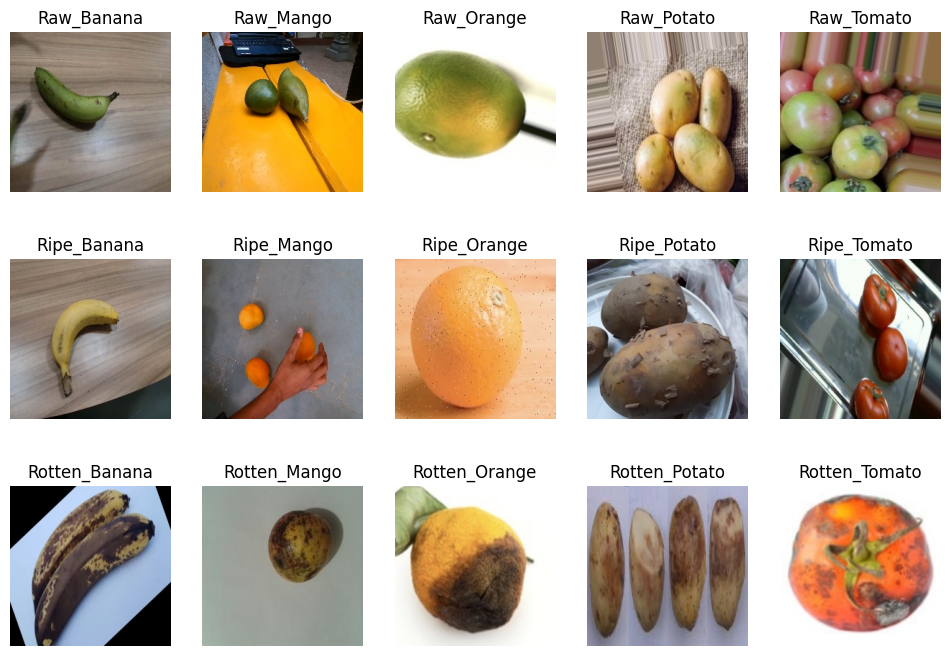

In [6]:
# display one sample per class in the dataset
fig, axs = plt.subplots(3, 5, figsize=(12, 8))
fig.subplots_adjust(hspace=0.4)
for i, (key, grp) in enumerate(Train_df.groupby('FolderName')):
    image_array = grp.iloc[0]['Image']
    axs[i // 5, i % 5].imshow(image_array)
    axs[i // 5, i % 5].set_title(key[2:])
    axs[i // 5, i % 5].axis('off')
plt.savefig("Dataset sample images.jpg")
plt.show()

In [7]:
Train_df['N'] ,Train_df['Quality'], Train_df['Type']=Train_df['FolderName'].str.split('_',2).str
Test_df['N'] ,Test_df['Quality'], Test_df['Type']=Test_df['FolderName'].str.split('_',2).str
Test_df.drop(['N'], axis=1, inplace=True)
Train_df.drop(['N'], axis=1, inplace=True)
Train_df2 = Train_df.copy()
Test_df2= Test_df.copy()


In [8]:
for i in Train_df2.FolderName.unique():
    if Train_df2[Train_df2['FolderName']==i].shape[0] < 500:
        temp = Train_df2[Train_df2['FolderName']==i]
        temp = temp.sample(frac=1, replace=True)
        Train_df2 = Train_df2.append(temp, ignore_index=True)
for i in Train_df2.FolderName.unique():
    if Train_df2[Train_df2['FolderName']==i].shape[0] > 1300:
        temp = Train_df2[Train_df2['FolderName']==i]
        temp = temp.head(1000)
        Train_df2 = Train_df2[Train_df2['FolderName']!=i]
        Train_df2 = Train_df2.append(temp, ignore_index=True)



In [9]:
for i in Test_df2.FolderName.unique():
    if Test_df2[Test_df2['FolderName']==i].shape[0] > 100:
        temp = Test_df2[Test_df2['FolderName']==i]
        temp = temp.head(100)
        Test_df2 = Test_df2[Test_df2['FolderName']!=i]
        Test_df2 = Test_df2.append(temp, ignore_index=True)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
num_samples, height, width, channels = X_train.shape
X_flattened = X_train.reshape(num_samples, height * width * channels)
scaler.fit(X_flattened)
X_train_scaled = scaler.transform(X_flattened)
X_train_scaled = X_train_scaled.reshape(num_samples, height, width, channels)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
num_samples, height, width, channels = X_test.shape
X_flattened = X_test.reshape(num_samples, height * width * channels)
scaler.fit(X_flattened)
X_test_scaled = scaler.transform(X_flattened)
X_test_scaled = X_test_scaled.reshape(num_samples, height, width, channels)



# Feature extraction


In [ ]:
# prompt: mobilennet v2 architecture for feature extraction from traning datate

from keras.applications import MobileNetV2

model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))


# ML classifiers

In [ ]:
KNN = KNeighborsClassifier()
KNN.fit(X_train_scaled.reshape(X_train.shape[0], height * width * channels),Y_train)
Y_pred_KNN = KNN.predict(X_test_scaled.reshape(X_test.shape[0], height * width * channels))



                 precision    recall  f1-score   support

   N_Raw_Banana       0.64      0.73      0.68      1249
    N_Raw_Mango       0.55      0.67      0.61      1250
   N_Raw_Orange       0.96      0.80      0.87      1280
   N_Raw_Potato       0.76      0.65      0.70      1215
   N_Raw_Tomato       0.64      0.40      0.49      1224
  N_Ripe_Banana       0.60      0.68      0.64      1250
   N_Ripe_Mango       0.56      0.82      0.66      1250
  N_Ripe_Orange       0.80      0.97      0.88      1430
  N_Ripe_Potato       0.39      0.67      0.50       611
  N_Ripe_Tomato       0.73      0.28      0.41       580
N_Rotten_Banana       0.99      0.81      0.89      2754
 N_Rotten_Mango       0.69      0.73      0.71       593
N_Rotten_Orange       0.83      0.87      0.85      1998
N_Rotten_Potato       0.75      0.38      0.51       585
N_Rotten_Tomato       0.67      0.59      0.63       596

       accuracy                           0.72     17865
      macro avg       0.70   

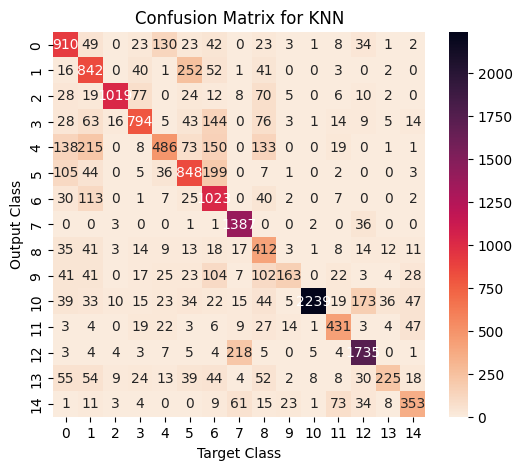


*Classification Report:
                  precision    recall  f1-score   support

   N_Raw_Banana       0.64      0.73      0.68      1249
    N_Raw_Mango       0.55      0.67      0.61      1250
   N_Raw_Orange       0.96      0.80      0.87      1280
   N_Raw_Potato       0.76      0.65      0.70      1215
   N_Raw_Tomato       0.64      0.40      0.49      1224
  N_Ripe_Banana       0.60      0.68      0.64      1250
   N_Ripe_Mango       0.56      0.82      0.66      1250
  N_Ripe_Orange       0.80      0.97      0.88      1430
  N_Ripe_Potato       0.39      0.67      0.50       611
  N_Ripe_Tomato       0.73      0.28      0.41       580
N_Rotten_Banana       0.99      0.81      0.89      2754
 N_Rotten_Mango       0.69      0.73      0.71       593
N_Rotten_Orange       0.83      0.87      0.85      1998
N_Rotten_Potato       0.75      0.38      0.51       585
N_Rotten_Tomato       0.67      0.59      0.63       596

       accuracy                           0.72     17865
   

()

In [ ]:
plot_conf_matrix(Y_test, Y_pred_KNN)
plot_classification_report(Y_test, Y_pred_KNN)

In [ ]:
DT = DecisionTreeClassifier(criterion='entropy')
DT.fit(X_train_scaled.reshape(X_train.shape[0], height * width * channels),Y_train)
Y_pred_DT = DT.predict(X_test_scaled.reshape(X_test.shape[0], height * width * channels))

# NN For 1 model
 data import

In [10]:
X_train = np.stack(Train_df2['Image'].values)
Y_train = np.stack(Train_df2['FolderName'].values)
X_test = np.stack(Test_df2['Image'].values)
Y_test = np.stack(Test_df2['FolderName'].values)

In [11]:
num_samples, height, width, channels = X_train.shape
num_classes = pd.unique(Y_train).shape[0]

## MNV2

In [12]:
base_model = MobileNetV2(input_shape=(height, width, channels), include_top=False, weights='imagenet')
model_MNV2 = Sequential()
model_MNV2.add(base_model)
model_MNV2.add(GlobalAveragePooling2D())
model_MNV2.add(Dense(256, activation='relu'))
model_MNV2.add(Dense(num_classes, activation='softmax'))

9406464/9406464 [==============================] - 1s 0us/step


In [13]:
from keras.utils import to_categorical
labels = pd.Categorical(Y_train)
num_classes = len(labels.categories)
y_one_hot = to_categorical(labels.codes, num_classes=num_classes)

In [78]:
learning_rate = 0.001
model_MNV2.compile(optimizer=Adam(lr=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
batch_size = 16
epochs = 10
MNV2_history = model_MNV2.fit(X_train, y_one_hot, batch_size=128, epochs=epochs, validation_split=0.25)

Epoch 1/10
88/88 [==============================] - 19s 148ms/step - loss: 0.0154 - accuracy: 0.9959 - val_loss: 20.4805 - val_accuracy: 0.4083
Epoch 2/10
88/88 [==============================] - 10s 118ms/step - loss: 0.0030 - accuracy: 0.9989 - val_loss: 20.3480 - val_accuracy: 0.4600
Epoch 3/10
88/88 [==============================] - 10s 119ms/step - loss: 0.0114 - accuracy: 0.9964 - val_loss: 18.1771 - val_accuracy: 0.4488
Epoch 4/10
88/88 [==============================] - 10s 118ms/step - loss: 0.0188 - accuracy: 0.9947 - val_loss: 21.4152 - val_accuracy: 0.4310
Epoch 5/10
88/88 [==============================] - 10s 118ms/step - loss: 0.0080 - accuracy: 0.9973 - val_loss: 25.0171 - val_accuracy: 0.4632
Epoch 6/10
88/88 [==============================] - 10s 119ms/step - loss: 0.0044 - accuracy: 0.9988 - val_loss: 22.4570 - val_accuracy: 0.4411
Epoch 7/10
88/88 [==============================] - 10s 118ms/step - loss: 0.0026 - accuracy: 0.9996 - val_loss: 25.3817 - val_accuracy:

()

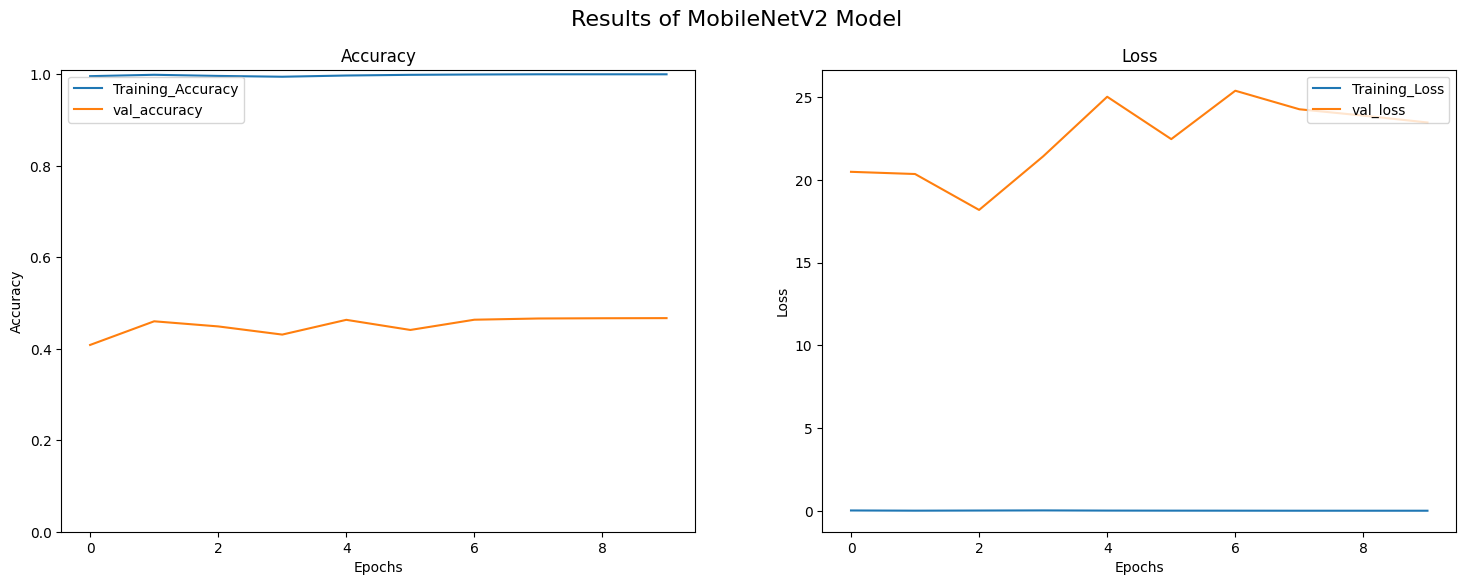

In [79]:
plot_acc_loss_curve(MNV2_history,'MobileNetV2')

In [115]:
model_MNV2.save('/content/drive/MyDrive/MNV2_1CLASSIFY_')

47/47 [==============================] - 1s 8ms/step
Test accuracy: 0.9796444444444444


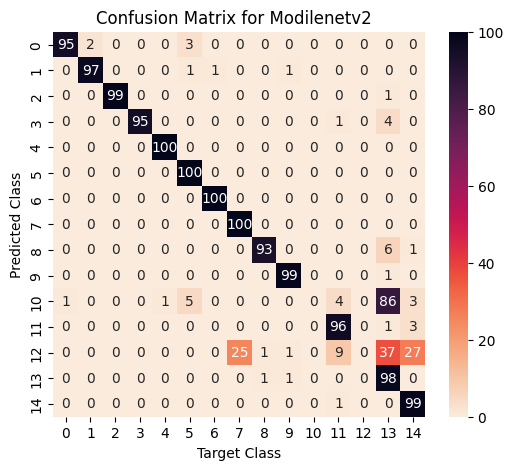

()

In [80]:
y_pred_probs = model_MNV2.predict(X_test)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
y_pred_original_labels = pd.Categorical.from_codes(y_pred_labels, categories=labels.categories)
y_pred_one_hot = to_categorical(y_pred_labels, num_classes=num_classes)
from keras.utils import to_categorical
labels = pd.Categorical(Y_test)
Y_one_hot_test = to_categorical(pd.Categorical(Y_test).codes, num_classes=15)
accuracy = np.mean(y_pred_one_hot == Y_one_hot_test)
print("Test accuracy:", accuracy)
plot_conf_matrix(labels ,y_pred_original_labels,'Modilenetv2')


In [17]:
plot_classification_report(labels ,y_pred_original_labels)


*Classification Report:
                  precision    recall  f1-score   support

   N_Raw_Banana       1.00      0.81      0.90       100
    N_Raw_Mango       0.88      0.96      0.92       100
   N_Raw_Orange       1.00      1.00      1.00       100
   N_Raw_Potato       1.00      0.72      0.84       100
   N_Raw_Tomato       0.98      0.95      0.96       100
  N_Ripe_Banana       0.94      0.65      0.77       100
   N_Ripe_Mango       0.99      0.97      0.98       100
  N_Ripe_Orange       0.81      0.89      0.85       100
  N_Ripe_Potato       0.70      0.78      0.74       100
  N_Ripe_Tomato       0.98      0.96      0.97       100
N_Rotten_Banana       0.00      0.00      0.00       100
 N_Rotten_Mango       0.28      0.99      0.44       100
N_Rotten_Orange       0.00      0.00      0.00       100
N_Rotten_Potato       0.69      0.34      0.46       100
N_Rotten_Tomato       0.66      1.00      0.79       100

       accuracy                           0.73      1500
   

()

In [ ]:
from PIL import Image
image_path='/content/tstresize.jpeg'
img = Image.open(image_path)
img = img.resize(img_shape)  # Resize the image to the desired size
img_array = np.array(img)
reshaped_img = img_array.reshape(1, 224, 224, 3)
y_pred_prob = model_MNV2.predict(reshaped_img)
y_pred_label = np.argmax(y_pred_prob, axis=1)
y_pred_original_label = pd.Categorical.from_codes(y_pred_label, categories=labels.categories)
print("Predicted lable of the tested type is " + y_pred_original_label[0])

1/1 [==============================] - 0s 48ms/step
Predicted lable of the tested type is N_Rotten_Banana


## VGG16


In [18]:
from tensorflow.keras.applications import VGG16

In [19]:
VGG_model= VGG16(input_shape=(height, width, channels), include_top=False, weights='imagenet')
model_VGG = Sequential()
model_VGG.add(VGG_model)
model_VGG.add(GlobalAveragePooling2D())
model_VGG.add(Dense(256, activation='relu'))
model_VGG.add(Dense(15, activation='softmax'))

58889256/58889256 [==============================] - 3s 0us/step


In [20]:
from keras.utils import to_categorical
labels = pd.Categorical(Y_train)
num_classes = len(labels.categories)
y_one_hot = to_categorical(labels.codes, num_classes=num_classes)
learning_rate = 0.001
model_VGG.compile(optimizer=Adam(lr=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
batch_size = 32
epochs = 10
VGG16_history = model_VGG.fit(X_train, y_one_hot, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/10
376/376 [==============================] - 27s 63ms/step - loss: 2.3892 - accuracy: 0.2228 - val_loss: 33.3853 - val_accuracy: 0.0533
Epoch 2/10
376/376 [==============================] - 21s 57ms/step - loss: 1.5176 - accuracy: 0.4502 - val_loss: 25.4599 - val_accuracy: 0.1460
Epoch 3/10
376/376 [==============================] - 21s 57ms/step - loss: 1.0781 - accuracy: 0.6310 - val_loss: 24.5380 - val_accuracy: 0.1929
Epoch 4/10
376/376 [==============================] - 21s 57ms/step - loss: 0.7284 - accuracy: 0.7516 - val_loss: 22.1157 - val_accuracy: 0.2283
Epoch 5/10
376/376 [==============================] - 21s 57ms/step - loss: 0.5731 - accuracy: 0.8090 - val_loss: 14.9211 - val_accuracy: 0.2476
Epoch 6/10
376/376 [==============================] - 22s 57ms/step - loss: 0.4672 - accuracy: 0.8456 - val_loss: 14.3002 - val_accuracy: 0.2736
Epoch 7/10
376/376 [==============================] - 22s 57ms/step - loss: 0.3974 - accuracy: 0.8693 - val_loss: 12.2225 - val_ac

In [114]:
model_VGG.save('/content/drive/MyDrive/VGG16_1CLASSIFY_')

()

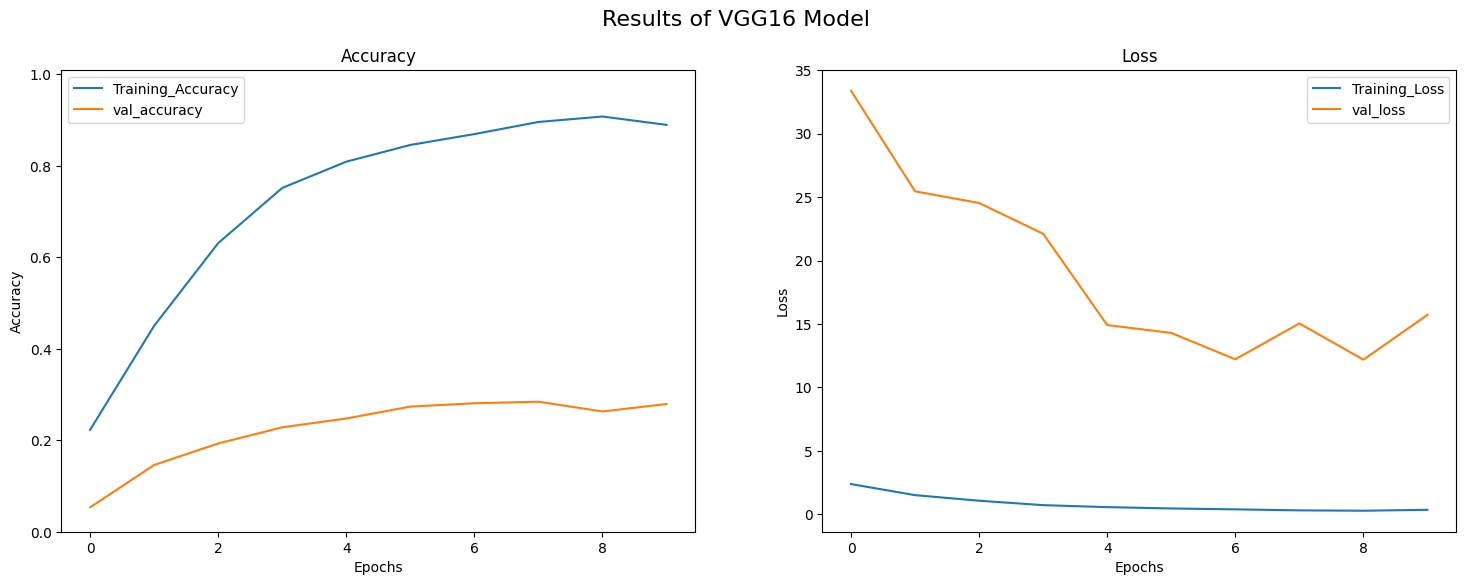

In [21]:
plot_acc_loss_curve(VGG16_history,'VGG16')

In [ ]:
from PIL import Image
image_path='/content/tstresize.jpeg'
img = Image.open(image_path)
img = img.resize(img_shape)  # Resize the image to the desired size
img_array = np.array(img)
reshaped_img = img_array.reshape(1, 224, 224, 3)
y_pred_prob = model_VGG.predict(reshaped_img)
y_pred_label = np.argmax(y_pred_prob, axis=1)
y_pred_original_label = pd.Categorical.from_codes(y_pred_label, categories=labels.categories)
print("Orignal lableof the tested type is " + y_pred_original_label[0])

1/1 [==============================] - 0s 250ms/step
Orignal lableof the tested type is N_Rotten_Potato


47/47 [==============================] - 2s 35ms/step
Test accuracy: 0.9530666666666666


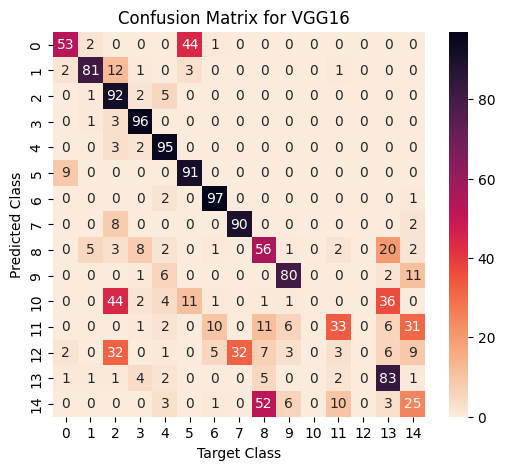

()

In [22]:
y_pred_probs = model_VGG.predict(X_test)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
y_pred_original_labels = pd.Categorical.from_codes(y_pred_labels, categories=labels.categories)
y_pred_one_hot = to_categorical(y_pred_labels, num_classes=num_classes)
y_pred_one_hot = to_categorical(y_pred_labels, num_classes=num_classes)
# Calculate the accuracy
from keras.utils import to_categorical
labels = pd.Categorical(Y_test)
Y_one_hot_test = to_categorical(pd.Categorical(Y_test).codes, num_classes=15)
accuracy = np.mean(y_pred_one_hot == Y_one_hot_test)
print("Test accuracy:", accuracy)

plot_conf_matrix(labels ,y_pred_original_labels,'VGG16')


## 4 layer CNN

In [75]:
model_4 = Sequential()
model_4.add(Conv2D(20, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(224, 224, 3)))
model_4.add(MaxPooling2D(pool_size=(2, 2)))
model_4.add(Conv2D(40, kernel_size=(3, 3), activation='sigmoid'))
model_4.add(MaxPooling2D(pool_size=(2, 2)))
model_4.add(Conv2D(60, kernel_size=(3, 3), activation='relu'))
model_4.add(MaxPooling2D(pool_size=(2, 2)))
model_4.add(Flatten())
model_4.add(Dense(128, activation='relu'))
model_4.add(Dense(64, activation='relu'))
model_4.add(Dense(15, activation='softmax'))
model_4.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
history_4Layer=model_4.fit(X_train, data_categorical(Y_train) , epochs=10,batch_size=128,validation_split=0.20)

Epoch 1/10
94/94 [==============================] - 6s 38ms/step - loss: 2.4688 - accuracy: 0.2699 - val_loss: 12.4400 - val_accuracy: 0.0297
Epoch 2/10
94/94 [==============================] - 2s 26ms/step - loss: 1.4301 - accuracy: 0.5216 - val_loss: 15.2460 - val_accuracy: 0.0850
Epoch 3/10
94/94 [==============================] - 2s 26ms/step - loss: 0.9830 - accuracy: 0.6757 - val_loss: 15.5551 - val_accuracy: 0.2439
Epoch 4/10
94/94 [==============================] - 2s 26ms/step - loss: 0.6748 - accuracy: 0.7720 - val_loss: 16.8969 - val_accuracy: 0.2769
Epoch 5/10
94/94 [==============================] - 2s 26ms/step - loss: 0.5262 - accuracy: 0.8215 - val_loss: 19.6973 - val_accuracy: 0.2869
Epoch 6/10
94/94 [==============================] - 2s 26ms/step - loss: 0.3926 - accuracy: 0.8675 - val_loss: 20.4258 - val_accuracy: 0.2782
Epoch 7/10
94/94 [==============================] - 2s 26ms/step - loss: 0.2767 - accuracy: 0.9084 - val_loss: 22.7928 - val_accuracy: 0.3059
Epoch 

In [113]:
model_4.save('/content/drive/MyDrive/4LAYER_1CLASSIFY_')

()

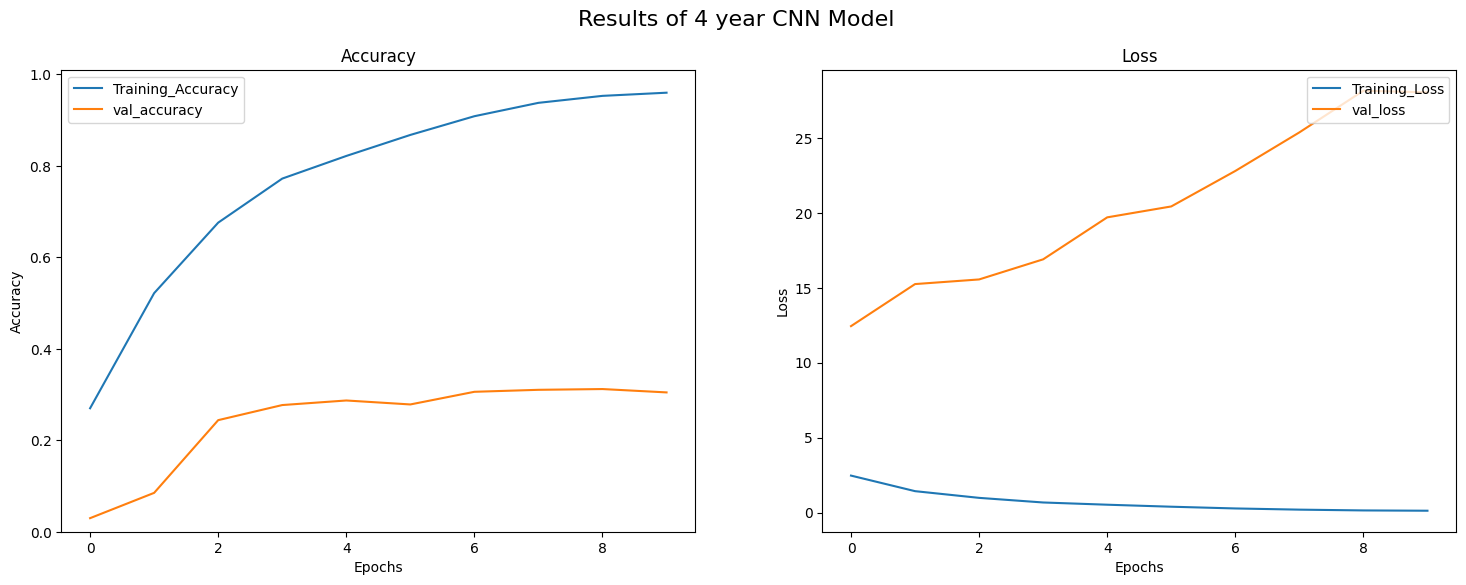

In [76]:
plot_acc_loss_curve(history_4Layer,'4 year CNN')

47/47 [==============================] - 0s 4ms/step
Test accuracy: 0.9522666666666667


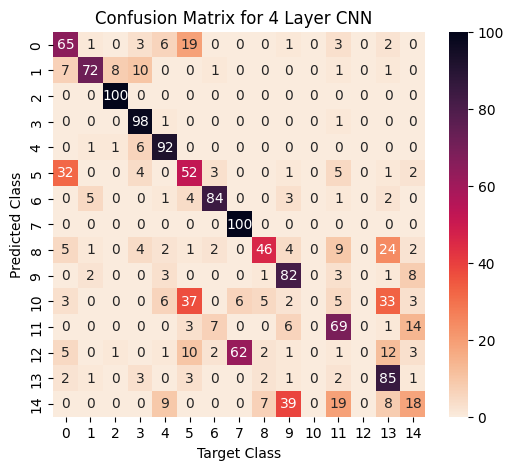

()

In [77]:
y_pred_probs = model_4.predict(X_test)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
labels = pd.Categorical(Y_test)
y_pred_original_labels = pd.Categorical.from_codes(y_pred_labels, categories=labels.categories)
y_pred_one_hot = to_categorical(y_pred_labels, num_classes=num_classes)
y_pred_one_hot = to_categorical(y_pred_labels, num_classes=num_classes)
# Calculate the accuracy
from keras.utils import to_categorical
labels = pd.Categorical(Y_test)
Y_one_hot_test = to_categorical(pd.Categorical(Y_test).codes, num_classes=15)
accuracy = np.mean(y_pred_one_hot == Y_one_hot_test)
print("Test accuracy:", accuracy)

plot_conf_matrix(labels ,y_pred_original_labels,'4 Layer CNN')


In [71]:
plot_classification_report(labels ,y_pred_original_labels)


*Classification Report:
                  precision    recall  f1-score   support

   N_Raw_Banana       0.71      0.47      0.57       100
    N_Raw_Mango       0.75      0.72      0.73       100
   N_Raw_Orange       0.99      0.94      0.96       100
   N_Raw_Potato       0.63      0.95      0.76       100
   N_Raw_Tomato       0.70      0.83      0.76       100
  N_Ripe_Banana       0.49      0.60      0.54       100
   N_Ripe_Mango       0.72      0.94      0.82       100
  N_Ripe_Orange       0.50      1.00      0.66       100
  N_Ripe_Potato       0.74      0.61      0.67       100
  N_Ripe_Tomato       0.74      0.73      0.74       100
N_Rotten_Banana       0.00      0.00      0.00       100
 N_Rotten_Mango       0.54      0.21      0.30       100
N_Rotten_Orange       0.00      0.00      0.00       100
N_Rotten_Potato       0.58      0.76      0.66       100
N_Rotten_Tomato       0.43      0.72      0.54       100

       accuracy                           0.63      1500
   

()

## EXTRA


In [ ]:
train_generator = train_datagen.flow_from_directory(Training_data,
                                                    target_size=img_shape,
                                                    color_mode='rgb',
                                                    seed=Seed,
                                                    batch_size=batch_size,
                                                    class_mode='sparse',
                                                    subset='training',
                                                    shuffle=True)
val_generator   = train_datagen.flow_from_directory(Training_data,
                                                    target_size=img_shape,
                                                    color_mode='rgb',
                                                    seed=Seed,
                                                    batch_size=batch_size,
                                                    class_mode='sparse',
                                                    subset='validation',
                                                    shuffle=True)
test_generator = test_datagen.flow_from_directory(Test_data,
                                                  target_size=img_shape,
                                                  color_mode='rgb',
                                                  seed=Seed,
                                                  batch_size=batch_size,
                                                  class_mode='sparse',
                                                  shuffle=False)

Found 10099 images belonging to 15 classes.
Found 4322 images belonging to 15 classes.
Found 3444 images belonging to 15 classes.


KeyboardInterrupt: ignored

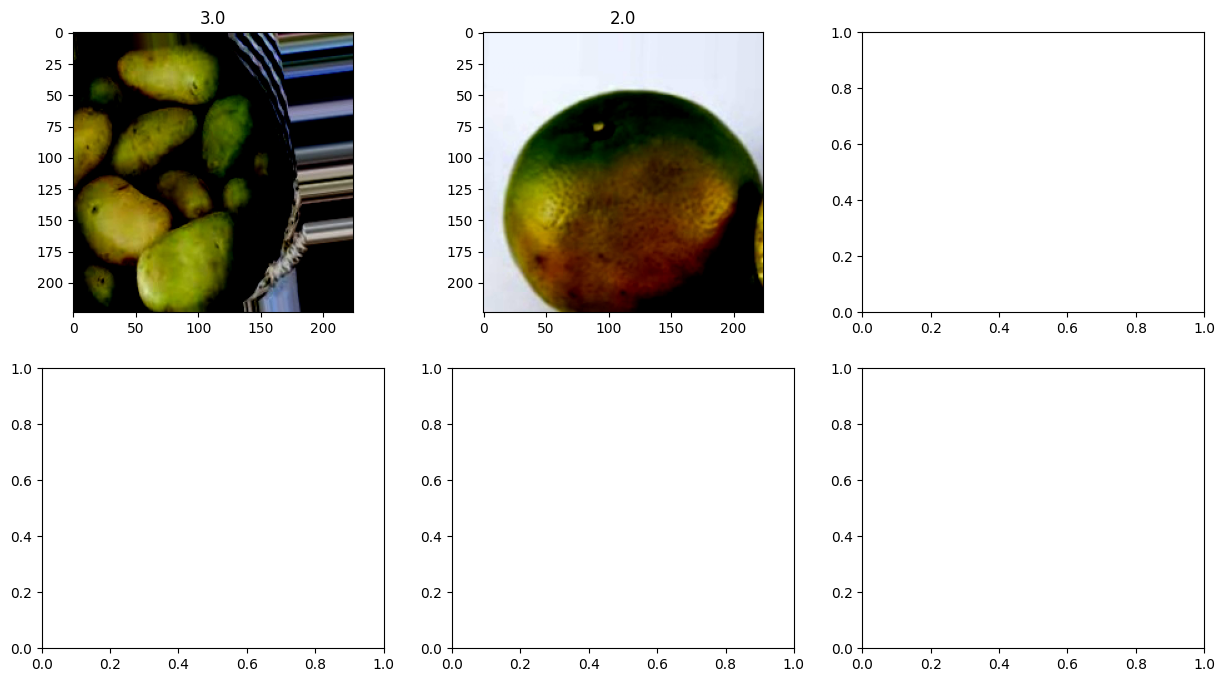

In [ ]:
fit, ax= plt.subplots(nrows=2, ncols=3, figsize=(15,8))
ax=ax.flatten()
j=0
for _ in range(6):
    img, label = train_generator.next()
    ax[j].imshow(img[0],)
    ax[j].set_title(label[0])
    #plt.show()
    j=j+1

In [ ]:
num_classes  = len(list(train_generator.class_indices.keys())) # number of classes in the Dataset

In [ ]:
# prompt: code for traing my images using modilenet v2 architecture without any transfer learning and plotting the acc and loss curve

from keras.applications.mobilenet_v2 import MobileNetV2
from keras.models import Model
import keras
MNV2 = MobileNetV2(include_top=True)
base_model = keras.Sequential(MNV2)
base_model.add(keras.layers.Dense(num_classes, activation = 'softmax'))

base_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = base_model.fit(train_generator, steps_per_epoch=800, epochs=20, validation_data=val_generator, validation_steps=200)

Epoch 1/20
 15/800 [..............................] - ETA: 1:05:34 - loss: 2.6922 - accuracy: 0.2083

KeyboardInterrupt: ignored

In [ ]:
#define the model
model = Sequential()
model.add(Conv2D(20, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(img_shape[0],img_shape[1],3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(40, kernel_size=(3,3), activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 222, 222, 20)      560       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 111, 111, 20)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 40)      7240      
                                                                 
 dense_6 (Dense)             (None, 109, 109, 100)     4100      
                                                                 
 flatten_1 (Flatten)         (None, 1188100)           0         
                                                                 
 dense_7 (Dense)             (None, 100)               118810100 
                                                      

In [ ]:
#defining the callbacks
callbacks = [ModelCheckpoint('model_chkpt/weights.{epoch:02d}_{val_loss:.4f}_{val_accuracy:.4f}.h5')] # this callback has been imported from a best prctise code from stackoverflow .cited as [1] in Readme

In [ ]:
results= model.fit(train_generator,
                    validation_data=val_generator,
                   callbacks= callbacks,
                    epochs=20,
                    )

Epoch 1/20
 38/158 [======>.......................] - ETA: 1:16:33 - loss: 4.6071 - accuracy: 0.2352

KeyboardInterrupt: ignored

# NN for 2 Models

In [23]:
X_train = np.stack(Train_df2['Image'].values)
Y_train_type = np.stack(Train_df2['Type'].values)
Y_train_Quality= np.stack(Train_df2['Quality'].values)
X_test = np.stack(Test_df2['Image'].values)
Y_test_type = np.stack(Test_df2['Type'].values)
Y_test_Quality= np.stack(Test_df2['Quality'].values)


In [24]:
def data_categorical(y):
  labels = pd.Categorical(y)
  num_classes = len(labels.categories)
  return to_categorical(labels.codes, num_classes=num_classes)

Y_train_hdh = data_categorical(Y_train_type)

Y_test_hdh = data_categorical(Y_test_type)



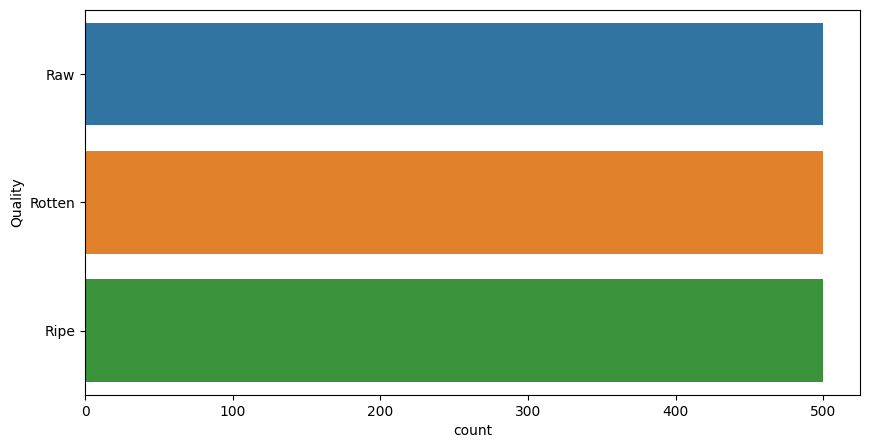

In [102]:
# prompt: diplay the bar plot of different classis in type in triandf

plt.figure(figsize=(10, 5))
sns.countplot(y=Test_df2['Quality'])
plt.show()


## MNV2


In [26]:
base_model_MNV2 = MobileNetV2(input_shape=(height, width, channels), include_top=False, weights='imagenet')
model_MNV2_Type = Sequential()
model_MNV2_Type.add(base_model_MNV2)
model_MNV2_Type.add(GlobalAveragePooling2D())
model_MNV2_Type.add(Dense(256, activation='relu'))
model_MNV2_Type.add(Dense(5, activation='softmax'))

In [81]:
learning_rate = 0.001
model_MNV2_Type.compile(optimizer=Adam(lr=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
batch_size = 16
epochs = 10
MNV2_history_Type = model_MNV2_Type.fit(X_train, data_categorical(Y_train_type) , batch_size=128, epochs=epochs, validation_split=0.25)

Epoch 1/10
88/88 [==============================] - 16s 133ms/step - loss: 0.0110 - accuracy: 0.9974 - val_loss: 2.3195 - val_accuracy: 0.6996
Epoch 2/10
88/88 [==============================] - 10s 118ms/step - loss: 0.0019 - accuracy: 0.9995 - val_loss: 7.1439 - val_accuracy: 0.5581
Epoch 3/10
88/88 [==============================] - 10s 119ms/step - loss: 1.0910e-04 - accuracy: 1.0000 - val_loss: 5.2344 - val_accuracy: 0.6418
Epoch 4/10
88/88 [==============================] - 10s 119ms/step - loss: 4.2306e-05 - accuracy: 1.0000 - val_loss: 5.0900 - val_accuracy: 0.6423
Epoch 5/10
88/88 [==============================] - 10s 119ms/step - loss: 1.2334e-05 - accuracy: 1.0000 - val_loss: 4.7496 - val_accuracy: 0.6541
Epoch 6/10
88/88 [==============================] - 10s 119ms/step - loss: 5.4516e-06 - accuracy: 1.0000 - val_loss: 4.3260 - val_accuracy: 0.6791
Epoch 7/10
88/88 [==============================] - 10s 119ms/step - loss: 6.9936e-06 - accuracy: 1.0000 - val_loss: 4.2377 - 

In [112]:
model_MNV2_Type.save('/content/drive/MyDrive/MNV2_TYPE')

47/47 [==============================] - 0s 8ms/step
Test accuracy for MNV2 Type classification: 0.9610666666666666


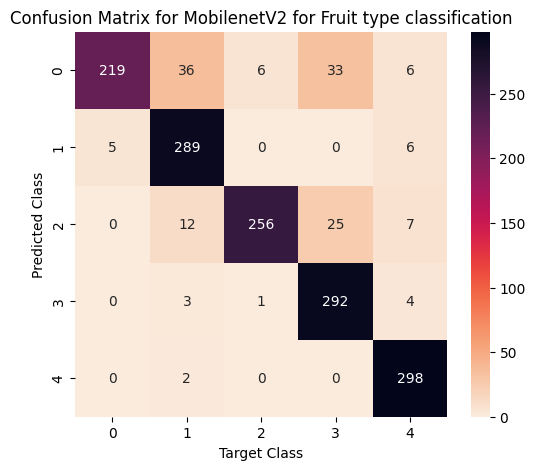

()

In [86]:
y_pred_probs = model_MNV2_Type.predict(X_test)
labels=pd.Categorical(Y_test_type)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
y_pred_original_labels = pd.Categorical.from_codes(y_pred_labels, categories=labels.categories)
y_pred_one_hot = to_categorical(y_pred_labels, num_classes=5)
# Calculate the accuracy
from keras.utils import to_categorical
labels = pd.Categorical(Y_test_type)
Y_one_hot_test = to_categorical(pd.Categorical(Y_test_type).codes, num_classes=5)
accuracy = np.mean(y_pred_one_hot == Y_one_hot_test)
print("Test accuracy for MNV2 Type classification:", accuracy)
plot_conf_matrix(labels ,y_pred_original_labels,'MobilenetV2 for','Fruit type classification')


In [29]:
base_model_MNV2 = MobileNetV2(input_shape=(height, width, channels), include_top=False, weights='imagenet')
model_MNV2_Quality = Sequential()
model_MNV2_Quality.add(base_model_MNV2)
model_MNV2_Quality.add(GlobalAveragePooling2D())
model_MNV2_Quality.add(Dense(256, activation='relu'))
model_MNV2_Quality.add(Dense(3, activation='softmax'))

In [98]:
learning_rate = 0.001
model_MNV2_Quality.compile(optimizer=Adam(lr=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
batch_size = 32
epochs = 10
MNV2_history_Quality = model_MNV2_Quality.fit(X_train, data_categorical(Y_train_Quality) , batch_size=128, epochs=epochs, validation_split=0.25)

Epoch 1/10
88/88 [==============================] - 17s 132ms/step - loss: 0.0101 - accuracy: 0.9968 - val_loss: 1.9822 - val_accuracy: 0.7220
Epoch 2/10
88/88 [==============================] - 10s 118ms/step - loss: 0.0039 - accuracy: 0.9988 - val_loss: 3.3131 - val_accuracy: 0.7164
Epoch 3/10
88/88 [==============================] - 10s 118ms/step - loss: 0.0052 - accuracy: 0.9981 - val_loss: 14.2574 - val_accuracy: 0.4813
Epoch 4/10
88/88 [==============================] - 10s 118ms/step - loss: 0.0094 - accuracy: 0.9973 - val_loss: 2.0463 - val_accuracy: 0.8699
Epoch 5/10
88/88 [==============================] - 10s 119ms/step - loss: 0.0024 - accuracy: 0.9990 - val_loss: 3.5496 - val_accuracy: 0.8100
Epoch 6/10
88/88 [==============================] - 10s 118ms/step - loss: 0.0010 - accuracy: 0.9996 - val_loss: 2.7288 - val_accuracy: 0.8446
Epoch 7/10
88/88 [==============================] - 10s 118ms/step - loss: 0.0021 - accuracy: 0.9994 - val_loss: 6.3285 - val_accuracy: 0.653

In [111]:
model_MNV2_Quality.save('/content/drive/MyDrive/MNV2_QUALITY')

47/47 [==============================] - 1s 9ms/step
Test accuracy for MNV2 Type classification: 0.8942222222222223


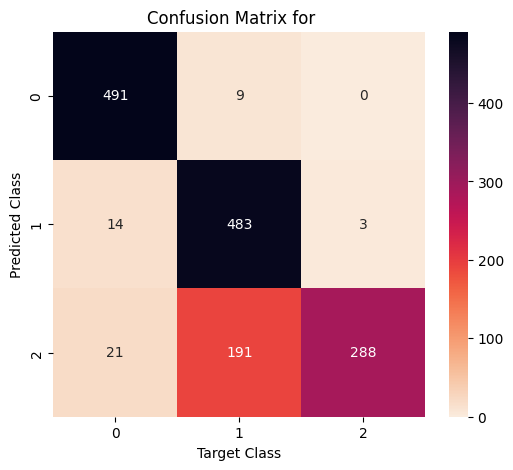

()

In [99]:
y_pred_probs = model_MNV2_Quality.predict(X_test)
labels=pd.Categorical(Y_test_Quality)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
y_pred_original_labels = pd.Categorical.from_codes(y_pred_labels, categories=labels.categories)
y_pred_one_hot = to_categorical(y_pred_labels, num_classes=3)
# Calculate the accuracy
from keras.utils import to_categorical
labels = pd.Categorical(Y_test_Quality)
Y_one_hot_test = to_categorical(pd.Categorical(Y_test_Quality).codes, num_classes=3)
accuracy = np.mean(y_pred_one_hot == Y_one_hot_test)
print("Test accuracy for MNV2 Type classification:", accuracy)
plot_conf_matrix(labels ,y_pred_original_labels)


()

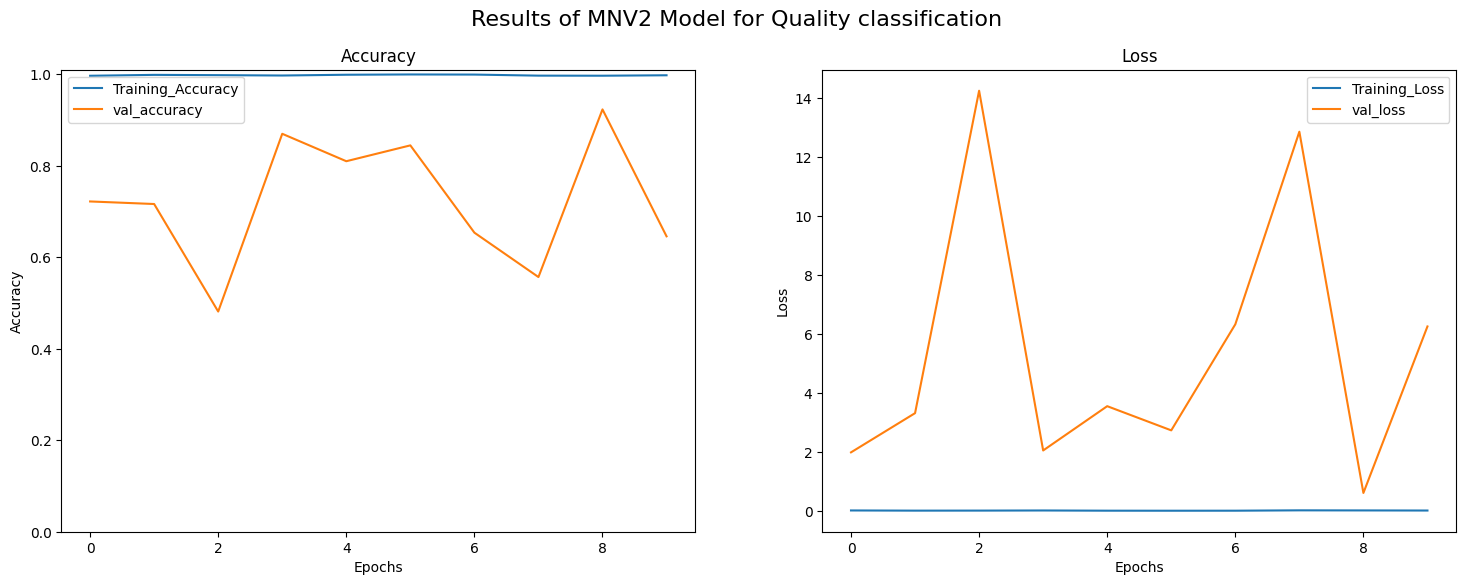

In [104]:
plot_acc_loss_curve(MNV2_history_Quality,'MNV2','Quality ')

()

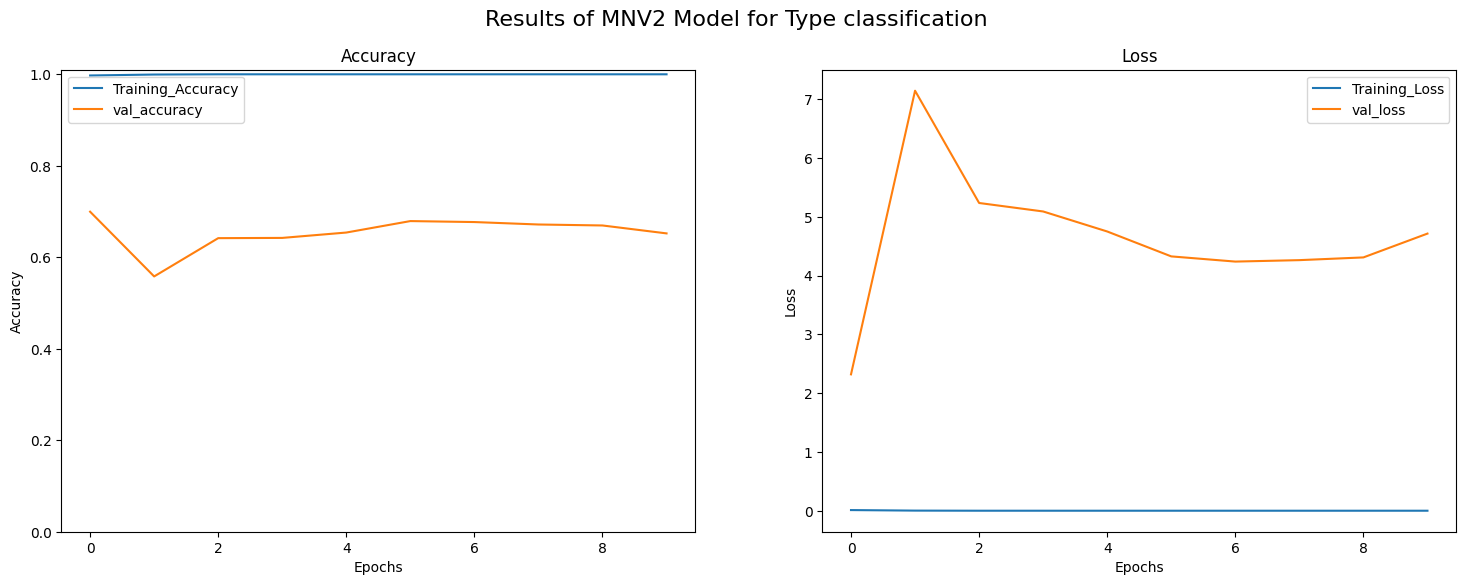

In [105]:
plot_acc_loss_curve(MNV2_history_Type,'MNV2','Type ')

In [100]:
plot_classification_report(labels ,y_pred_original_labels)


*Classification Report:
               precision    recall  f1-score   support

         Raw       0.93      0.98      0.96       500
        Ripe       0.71      0.97      0.82       500
      Rotten       0.99      0.58      0.73       500

    accuracy                           0.84      1500
   macro avg       0.88      0.84      0.83      1500
weighted avg       0.88      0.84      0.83      1500



()

## 4 layer CNN


In [32]:
# define the model
model_4_Type = Sequential()
model_4_Type.add(Conv2D(20, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(224, 224, 3)))
model_4_Type.add(MaxPooling2D(pool_size=(2, 2)))
model_4_Type.add(Conv2D(40, kernel_size=(3, 3), activation='sigmoid'))
model_4_Type.add(MaxPooling2D(pool_size=(2, 2)))
model_4_Type.add(Conv2D(60, kernel_size=(3, 3), activation='relu'))
model_4_Type.add(MaxPooling2D(pool_size=(2, 2)))
model_4_Type.add(Flatten())
model_4_Type.add(Dense(128, activation='relu'))
model_4_Type.add(Dense(64, activation='relu'))
model_4_Type.add(Dense(5, activation='softmax'))
model_4_Type.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [92]:
Type_4_history=model_4_Type.fit(X_train, data_categorical(Y_train_type) , epochs=10,batch_size=128,validation_split=0.25)

Epoch 1/10
88/88 [==============================] - 3s 31ms/step - loss: 0.0121 - accuracy: 0.9964 - val_loss: 3.9915 - val_accuracy: 0.7183
Epoch 2/10
88/88 [==============================] - 2s 26ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 4.0635 - val_accuracy: 0.7196
Epoch 3/10
88/88 [==============================] - 2s 27ms/step - loss: 9.9511e-04 - accuracy: 1.0000 - val_loss: 4.0682 - val_accuracy: 0.7196
Epoch 4/10
88/88 [==============================] - 2s 27ms/step - loss: 7.2936e-04 - accuracy: 1.0000 - val_loss: 4.0808 - val_accuracy: 0.7215
Epoch 5/10
88/88 [==============================] - 2s 27ms/step - loss: 5.6742e-04 - accuracy: 1.0000 - val_loss: 4.0898 - val_accuracy: 0.7228
Epoch 6/10
88/88 [==============================] - 2s 27ms/step - loss: 4.3278e-04 - accuracy: 1.0000 - val_loss: 4.1246 - val_accuracy: 0.7265
Epoch 7/10
88/88 [==============================] - 2s 27ms/step - loss: 3.1026e-04 - accuracy: 1.0000 - val_loss: 4.1426 - val_accuracy: 

In [110]:
model_4_Type.save('/content/drive/MyDrive/4LAYER_TYPE')

In [87]:
model_4_Quality = Sequential()
model_4_Quality.add(Conv2D(20, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(224, 224, 3)))
model_4_Quality.add(MaxPooling2D(pool_size=(2, 2)))
model_4_Quality.add(Conv2D(40, kernel_size=(3, 3), activation='sigmoid'))
model_4_Quality.add(MaxPooling2D(pool_size=(2, 2)))
model_4_Quality.add(Conv2D(60, kernel_size=(3, 3), activation='relu'))
model_4_Quality.add(MaxPooling2D(pool_size=(2, 2)))
model_4_Quality.add(Flatten())
model_4_Quality.add(Dense(128, activation='relu'))
model_4_Quality.add(Dense(64, activation='relu'))
model_4_Quality.add(Dense(3, activation='softmax'))
model_4_Quality.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
Quality_4_history=model_4_Quality.fit(X_train, data_categorical(Y_train_Quality) , epochs=10,batch_size=128,validation_split=0.25)

Epoch 1/10
88/88 [==============================] - 5s 33ms/step - loss: 0.9538 - accuracy: 0.6679 - val_loss: 4.7654 - val_accuracy: 0.1167
Epoch 2/10
88/88 [==============================] - 2s 27ms/step - loss: 0.4725 - accuracy: 0.8075 - val_loss: 6.2198 - val_accuracy: 0.3124
Epoch 3/10
88/88 [==============================] - 2s 26ms/step - loss: 0.3812 - accuracy: 0.8451 - val_loss: 5.8029 - val_accuracy: 0.3390
Epoch 4/10
88/88 [==============================] - 2s 27ms/step - loss: 0.3189 - accuracy: 0.8735 - val_loss: 7.8166 - val_accuracy: 0.4296
Epoch 5/10
88/88 [==============================] - 2s 27ms/step - loss: 0.2604 - accuracy: 0.8927 - val_loss: 9.9219 - val_accuracy: 0.4579
Epoch 6/10
88/88 [==============================] - 2s 27ms/step - loss: 0.2035 - accuracy: 0.9206 - val_loss: 15.3839 - val_accuracy: 0.4310
Epoch 7/10
88/88 [==============================] - 2s 27ms/step - loss: 0.1888 - accuracy: 0.9246 - val_loss: 16.2164 - val_accuracy: 0.4256
Epoch 8/10


In [109]:
model_4_Quality.save('/content/drive/MyDrive/4LAYER_QUALITY')

()

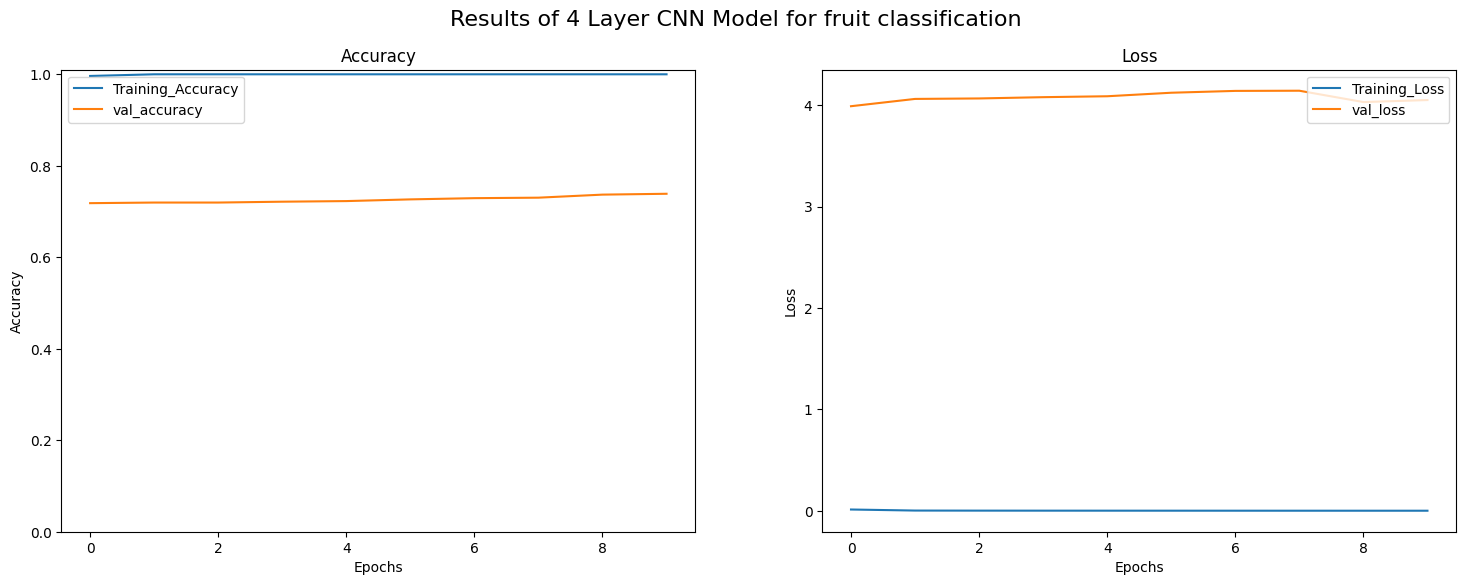

In [106]:
plot_acc_loss_curve(Type_4_history,'4 Layer CNN','fruit ')

()

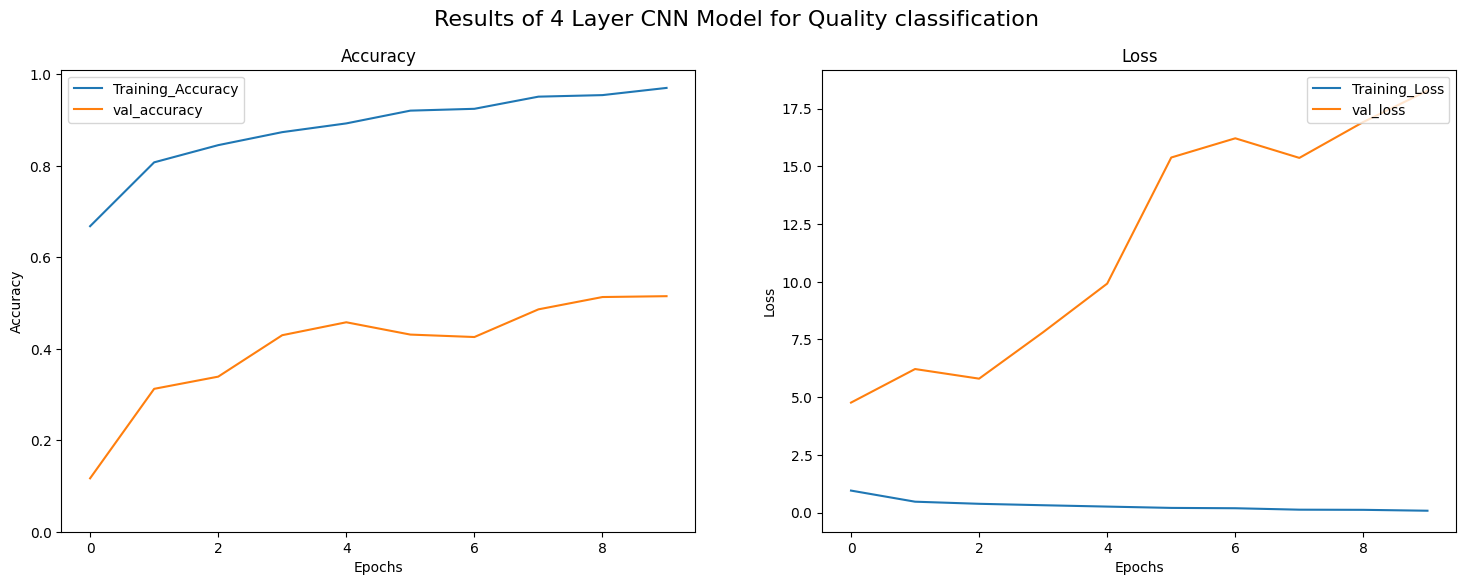

In [107]:
plot_acc_loss_curve(Quality_4_history,'4 Layer CNN','Quality ')

47/47 [==============================] - 0s 4ms/step
Test accuracy for Type classification: 0.9069333333333334


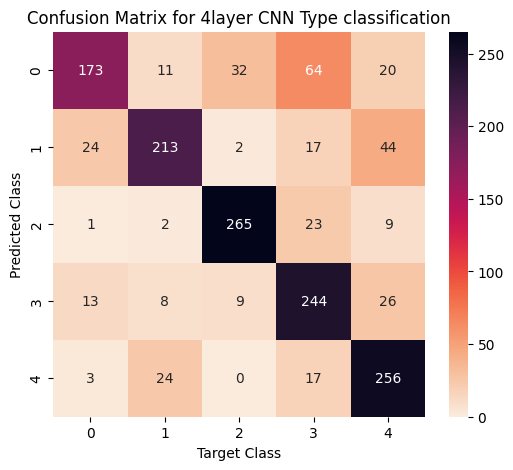

()

In [95]:
y_pred_probs = model_4_Type.predict(X_test)
labels=pd.Categorical(Y_test_type)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
y_pred_original_labels = pd.Categorical.from_codes(y_pred_labels, categories=labels.categories)
y_pred_one_hot = to_categorical(y_pred_labels, num_classes=5)
# Calculate the accuracy
from keras.utils import to_categorical
labels = pd.Categorical(Y_test_type)
Y_one_hot_test = to_categorical(pd.Categorical(Y_test_type).codes, num_classes=5)
accuracy = np.mean(y_pred_one_hot == Y_one_hot_test)
print("Test accuracy for Type classification:", accuracy)
plot_conf_matrix(labels ,y_pred_original_labels,'4layer CNN','Type classification')

47/47 [==============================] - 0s 4ms/step
Test accuracy for quality classification: 0.8102222222222222


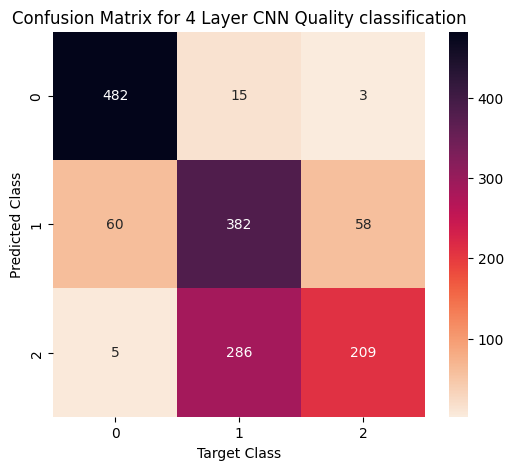

()

In [97]:
y_pred_probs = model_4_Quality.predict(X_test)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
y_pred_original_labels = pd.Categorical.from_codes(y_pred_labels, categories=labels.categories)
y_pred_one_hot = to_categorical(y_pred_labels, num_classes=3)
from keras.utils import to_categorical
labels = pd.Categorical(Y_test_Quality)
Y_one_hot_test = to_categorical(pd.Categorical(Y_test_Quality).codes, num_classes=3)
accuracy = np.mean(y_pred_one_hot == Y_one_hot_test)
print("Test accuracy for quality classification:", accuracy)
plot_conf_matrix(labels ,y_pred_original_labels,'4 Layer CNN','Quality classification')
